# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())
# mcolors.__dict__
# colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

register_cmaps()
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

In [3]:
def make_hic_from_com(fig, ax, com_arr, sigma=.02, log=True, vmin=-40, vmax=0, radius=.01):
    sep_mat = com_arr[:, None, :] - com_arr[None, :, :]
    dist_sqrd_mat = np.einsum('ijk,ijk->ij', sep_mat, sep_mat)
    if log:
        contact_mat =  - dist_sqrd_mat / (2 * sigma**2)
    else: 
        contact_mat = np.exp(-dist_sqrd_mat / (2. * sigma**2))

    c = ax.pcolorfast(contact_mat, vmin=vmin, vmax=vmax)

    # ax.invert_yaxis()
    fig.colorbar(c, ax=ax,
                    # label=r"$\\log$(Inferred contact map) $\\sim$
                    # ($r_{{ij}}^2/2\\sigma^2$)")
                    label=r"Log contact probability $\sim$ ($-r_{{ij}}^2$)",
                    )
    ax.set_aspect('equal')
    ax.invert_yaxis()

    # ax.set_title(r'1 bead $\sim$ 200-400 bp')
    ax.set_xlabel("Bead index")
    ax.set_ylabel("Bead index")
    plt.tight_layout()


Final snapshot of the baseline simulation at 3um separation and Ke=100
<img width="50%" src="./3um_Ke100_snap.png"></img>

## Figure 1c contact graphs

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


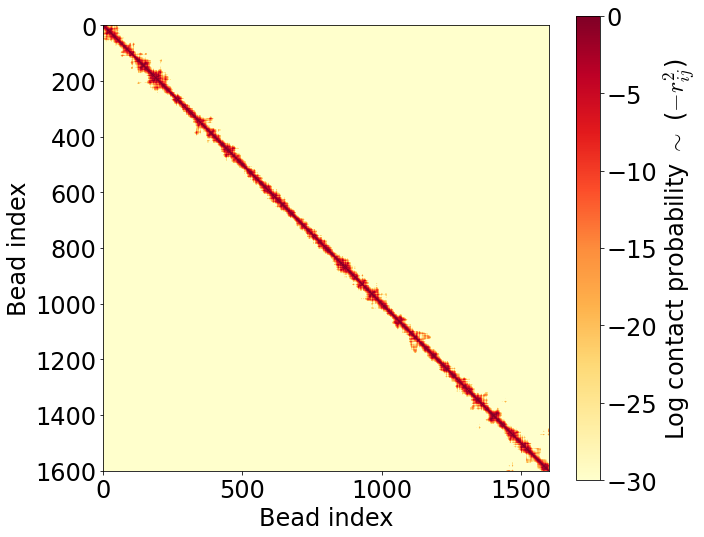

In [4]:
# Uncondensed relgular contact graph
data_path = ceph_path / 'CondCharPaper/22-09_aLc1_scan6.12_line200-6400_sticky_runs/simulations/line1600/simulations/s1'
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    fig, ax = plt.subplots(figsize=(10, 8))  

    make_hic_from_com(fig, ax, com_arr[:,:,0], sigma=.025, log=True, vmin=-30)





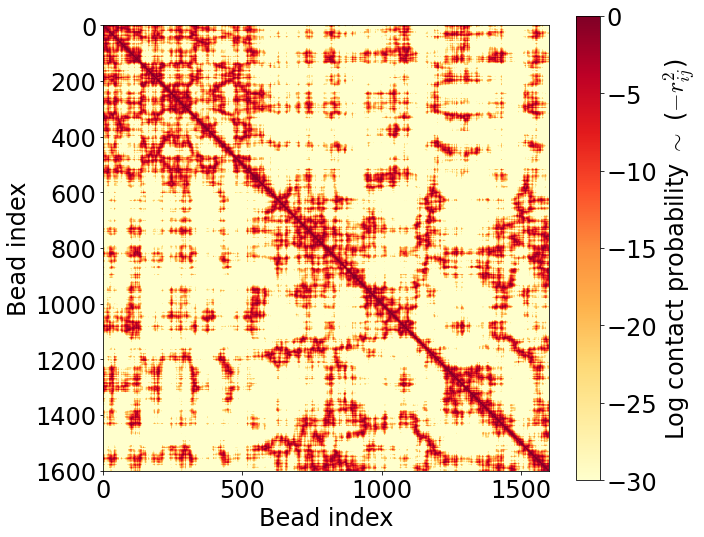

In [5]:
# Uncondensed relgular contact graph
data_path = ceph_path / 'CondCharPaper/22-09_aLc1_scan6.12_line200-6400_sticky_runs/simulations/line1600/simulations/s1'
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    fig, ax = plt.subplots(figsize=(10, 8))  

    make_hic_from_com(fig, ax, com_arr[:,:,-1], sigma=.025, log=True, vmin=-30)






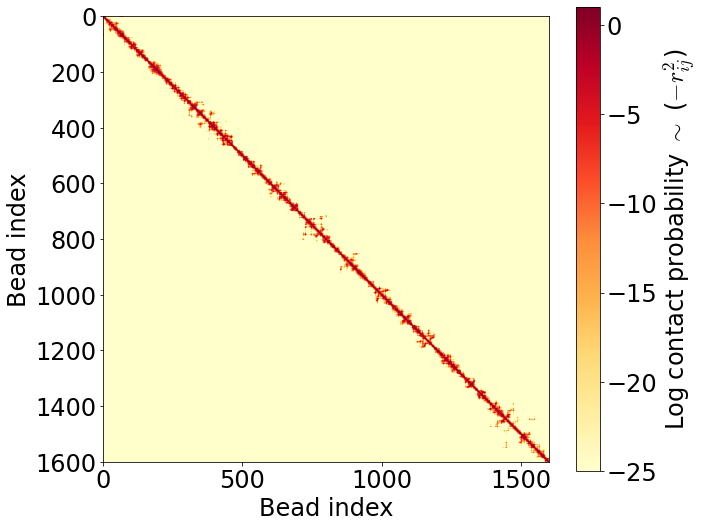

In [6]:
# Uncondensed pinned contact graph
data_path = ceph_path / 'DynCondPaper/23-10-20_aLc1_slice8.7._line1600_Pin1-13um_Ke.1-300/simulations/Ke100_Pin3.0um/'
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    fig, ax = plt.subplots(figsize=(10, 8))  

    make_hic_from_com(fig, ax, com_arr[:,:,0], log=True, vmin=-25, vmax=1, sigma=.01, radius=.005)

fig.savefig('Figure1/uncondensed_pinned_fig1c.png', dpi=600, bbox_inches='tight')


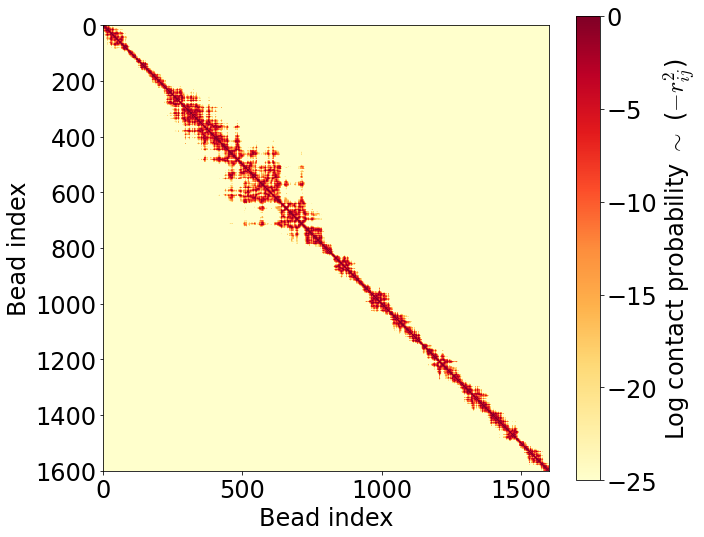

In [7]:
# Uncondensed contact graph
data_path = ceph_path / 'DynCondPaper/23-10-20_aLc1_slice8.7._line1600_Pin1-13um_Ke.1-300/simulations/Ke300_Pin3.0um/'
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    fig, ax = plt.subplots(figsize=(10, 8))  

    make_hic_from_com(fig, ax, com_arr[:,:,-1], log=True, vmin=-25, sigma=.01, radius=.005)

fig.savefig('Figure1/condensed_pinned_fig1.png', dpi=600, bbox_inches='tight')





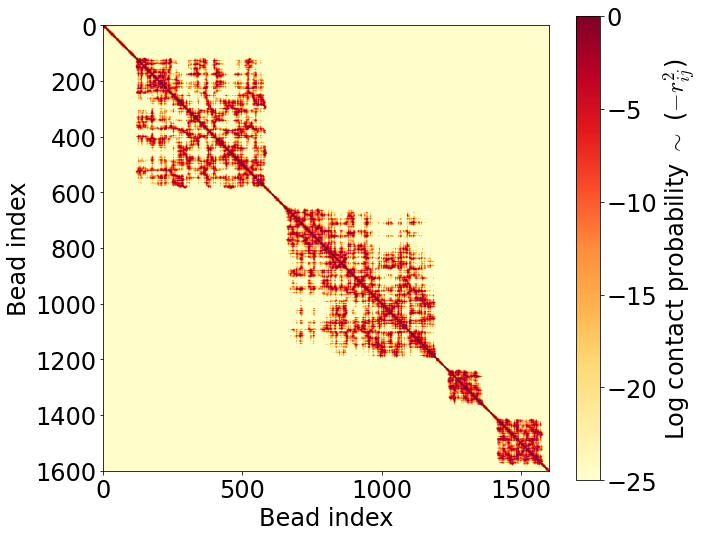

In [8]:
# Uncondensed contact graph
data_path = ceph_path / 'DynCondPaper/23-10-20_aLc1_slice8.7._line1600_Pin1-13um_2xKe.1-300_ks100/simulations/Ke100_Pin3.0um/'
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    fig, ax = plt.subplots(figsize=(10, 8))  

    make_hic_from_com(fig, ax, com_arr[:,:,-1], log=True, vmin=-25, sigma=.01, radius=.005)

fig.savefig('Figure1/condensed_pinned_fig1.png', dpi=600, bbox_inches='tight')





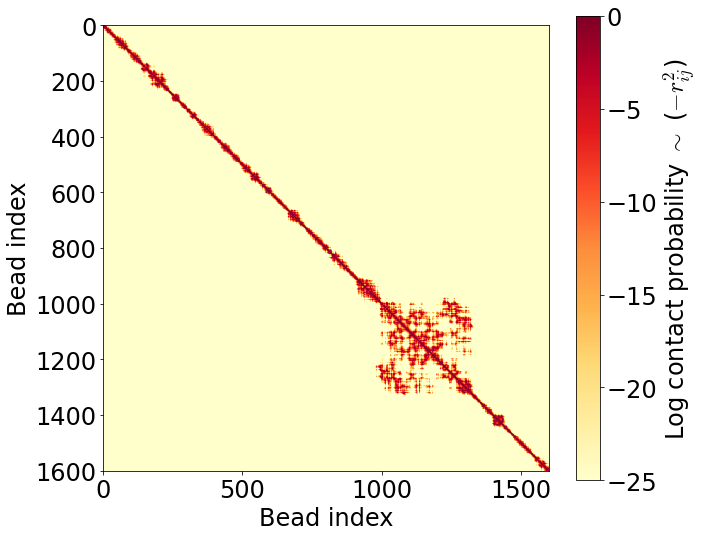

In [9]:
# Uncondensed contact graph
data_path = ceph_path / 'DynCondPaper/23-10-20_aLc1_slice8.7._line1600_Pin1-13um_Ke.1-300_ks100/simulations/Ke100_Pin5.0um/'
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    fig, ax = plt.subplots(figsize=(10, 8))  

    make_hic_from_com(fig, ax, com_arr[:,:,-1], log=True, vmin=-25, sigma=.01, radius=.005)

fig.savefig('Figure1/condensed_pinned_fig1.png', dpi=600, bbox_inches='tight')





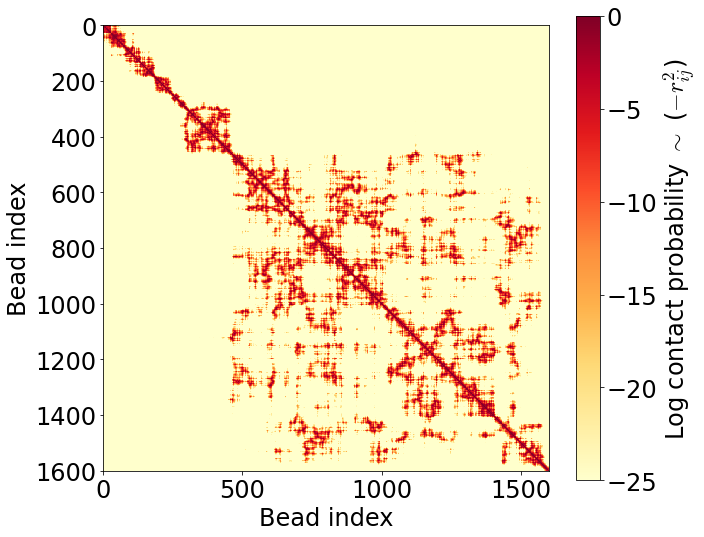

In [10]:
# Uncondensed contact graph
data_path = ceph_path / 'DynCondPaper/23-10-20_aLc1_slice8.7._line1600_Pin1-13um_Ke.1-300/simulations/Ke100_Pin1.0um/'
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    fig, ax = plt.subplots(figsize=(10, 8))  

    make_hic_from_com(fig, ax, com_arr[:,:,-1], log=True, vmin=-25, sigma=.01, radius=.005)




